# CPU-Based Object Detection with GroundingDINO and SAM

This notebook demonstrates how to set up and run **GroundingDINO** combined with **Segment Anything Model (SAM)** on a CPU, using a text prompt to detect objects in an image.

---

## 1️⃣ Import Required Libraries

```python
import os
import shutil
import torch, cv2, numpy as np
from sklearn.cluster import DBSCAN
from PIL import Image
import open_clip
import re
from groundingdino.util.inference import load_model, load_image, predict, annotate
from segment_anything import sam_model_registry, SamPredictor


In [42]:
import os
import shutil
import torch, cv2, numpy as np
from sklearn.cluster import DBSCAN
from PIL import Image
import open_clip
import re
from groundingdino.util.inference import load_model, load_image, predict, annotate
from segment_anything import sam_model_registry, SamPredictor


IMAGE_PATH = "test.jpg"
TEXT_PROMPT = "tow  man riding horses"
DEVICE = "cpu"

# Prompt Analysis and Threshold Selection for Object Detection

This section adds **adaptive threshold selection** based on the prompt complexity. It also includes **DBSCAN-based merging** of multiple bounding boxes and **CLIP similarity scoring**.

---

- Calculates center coordinates $(cx, cy)$ of each bounding box.
- Clusters box centers with DBSCAN (optional, mostly to merge close boxes).
- Merges all boxes into one bounding box by taking min/max coordinates.

Formula for center coordinates:

$$
cx = \frac{x_{min} + x_{max}}{2}, \quad cy = \frac{y_{min} + y_{max}}{2}
$$

Merged box coordinates:

$$
x_{min}^{merged} = \min(x_{min}), \quad y_{min}^{merged} = \min(y_{min}), \quad x_{max}^{merged} = \max(x_{max}), \quad y_{max}^{merged} = \max(y_{max})
$$



- Preprocess image and prompt for CLIP.
- Encode image and text to feature vectors.
- Normalize vectors and calculate cosine similarity:

$$
\text{similarity} = \frac{\text{img\_feat} \cdot \text{txt\_feat}}{\|\text{img\_feat}\| \|\text{txt\_feat}\|}
$$

Returns a score between -1 and 1 indicating how well the image matches the prompt.



In [43]:
# ===== Added: Prompt Analysis for Threshold Selection =====
THRESHOLD_PRESETS = {
    "low":    [(0.05, 0.25), (0.10, 0.28), (0.20, 0.30)],  # for many items
    "medium": [(0.15, 0.32), (0.15, 0.35), (0.18, 0.38)],  # for average prompts
    "high":   [(0.30, 0.40), (0.35, 0.45), (0.25, 0.50)]   # for very specific
}

def analyze_prompt(prompt: str):
    prompt_clean = prompt.lower().strip()
    objects = re.split(r',| and ', prompt_clean)
    objects = [obj.strip() for obj in objects if obj.strip()]
    num_objects = len(objects)

    if num_objects >= 3:
        category = "low"
    elif num_objects == 2:
        category = "medium"
    else:
        category = "high"

    return category, THRESHOLD_PRESETS[category]

def dbscan_merge_to_single_box(boxes_xyxy_np, eps_frac=0.05):
    """Merge all boxes into a single one after optional DBSCAN clustering."""
    if len(boxes_xyxy_np) == 0:
        return None
    # Cluster centers
    centers = np.column_stack((
        (boxes_xyxy_np[:, 0] + boxes_xyxy_np[:, 2]) / 2.0,  # cx
        (boxes_xyxy_np[:, 1] + boxes_xyxy_np[:, 3]) / 2.0   # cy
    ))
    # Note: W and H are accessed from the global scope here
    eps = eps_frac * max(W, H)
    _ = DBSCAN(eps=eps, min_samples=1).fit(centers)  # not using clusters, just merging all

    # Merge all into one
    x_min = boxes_xyxy_np[:, 0].min()
    y_min = boxes_xyxy_np[:, 1].min()
    x_max = boxes_xyxy_np[:, 2].max()
    y_max = boxes_xyxy_np[:, 3].max()
    return np.array([[x_min, y_min, x_max, y_max]], dtype=np.float32)

def clip_similarity_score(image_path: str, prompt: str) -> float:
    """Get CLIP cosine similarity between image and prompt."""
    img_clip = clip_preprocess(Image.open(image_path)).unsqueeze(0).to(DEVICE)
    text_clip = tokenizer([prompt]).to(DEVICE)
    with torch.no_grad():
        img_feat = clip_model.encode_image(img_clip)
        txt_feat = clip_model.encode_text(text_clip)
        img_feat /= img_feat.norm(dim=-1, keepdim=True)
        txt_feat /= txt_feat.norm(dim=-1, keepdim=True)
        similarity = (img_feat @ txt_feat.T).item()
    return similarity

# Setup: Load Models, Image, and Thresholds

This section demonstrates **loading all required models**, performing **prompt analysis**, and setting up directories for output.

-------



In [44]:

category, THRESHOLD_PAIRS = analyze_prompt(TEXT_PROMPT)
print(f"[Prompt Analysis] Category: {category}, Thresholds: {THRESHOLD_PAIRS}")

# Load GroundingDINO
dino_config_path = "groundingdino/config/GroundingDINO_SwinT_OGC.py"
dino_weights_path = "weights/groundingdino_swint_ogc copy.pth"
dino_model = load_model(dino_config_path, dino_weights_path)
dino_model.to(DEVICE).eval()

# Load image once
image_source, image = load_image(IMAGE_PATH)  # image_source: RGB np.ndarray
H, W = image_source.shape[:2]

# Load SAM
sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
sam_model = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
sam_model.to(DEVICE)
sam_predictor = SamPredictor(sam_model)
sam_predictor.set_image(image_source)

# Load CLIP
clip_model, _, clip_preprocess = open_clip.create_model_and_transforms("ViT-B-32", pretrained="openai")
clip_model.to(DEVICE).eval()
tokenizer = open_clip.get_tokenizer("ViT-B-32")

# Output dir
OUTDIR = "threshold_runs"
os.makedirs(OUTDIR, exist_ok=True)

[Prompt Analysis] Category: high, Thresholds: [(0.3, 0.4), (0.35, 0.45), (0.25, 0.5)]
final text_encoder_type: bert-base-uncased


## 🧠 Workflow Overview: Detection, Segmentation & Scoring

---

###  Step 1: Iterate Over Threshold Pairs
- Loop through each `(box_threshold, text_threshold)` in `THRESHOLD_PAIRS`.
- Create a unique `run_tag` for each configuration.

---

###  Step 2: GroundingDINO Detection
- Use `predict()` to detect bounding boxes and phrases:
  - Inputs: image, text prompt, thresholds.
  - Outputs: `boxes_t`, `logits_t`, `phrases`.
- If no boxes are detected:
  - Append result with score `-1.0`.
  - Skip to next iteration.

---

###  Step 3: Merge Boxes
- Convert `boxes_t` to NumPy array.
- Merge close boxes using `dbscan_merge_to_single_box()`.

---

###  Step 4: Annotate Merged Box
- Use `annotate()` to draw merged box and label.
- Save annotated image to:


In [45]:
results = []

for i, (box_th, text_th) in enumerate(THRESHOLD_PAIRS):
    run_tag = f"run_{i}_b{box_th:.2f}_t{text_th:.2f}"

    # ---- GroundingDINO detection
    boxes_t, logits_t, phrases = predict(
        model=dino_model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=box_th,
        text_threshold=text_th,
        device=DEVICE
    )

    if len(boxes_t) == 0:
        results.append({"score": -1.0, "pair": (box_th, text_th), "annot_path": None, "mask_path": None})
        print(f"[{run_tag}] No detections -> CLIP score = -1")
        continue

    # ---- Merge boxes to one
    boxes_np = boxes_t.detach().cpu().numpy().astype(np.float32)
    merged_np = dbscan_merge_to_single_box(boxes_np, eps_frac=0.05)
    merged_t = torch.from_numpy(merged_np)

    # ---- Annotate merged box
    annot_img = annotate(image_source, merged_t, logits=torch.ones((1,)), phrases=[TEXT_PROMPT])
    annot_path = os.path.join(OUTDIR, f"{run_tag}_annot.png")
    cv2.imwrite(annot_path, cv2.cvtColor(annot_img, cv2.COLOR_RGB2BGR))

    # ---- SAM segmentation
    image_bgr = cv2.cvtColor(image_source, cv2.COLOR_RGB2BGR)
    masks, _, _ = sam_predictor.predict(box=merged_np[0], multimask_output=False)
    mask_img = image_bgr.copy()
    mask_img[masks[0]] = (0, 255, 0)  # green overlay
    mask_path = os.path.join(OUTDIR, f"{run_tag}_mask.png")
    cv2.imwrite(mask_path, mask_img)

    # ---- CLIP scoring
    score = clip_similarity_score(annot_path, TEXT_PROMPT)
    results.append({"score": score, "pair": (box_th, text_th), "annot_path": annot_path, "mask_path": mask_path})
    print(f"[{run_tag}] CLIP score = {score:.4f}")

[run_0_b0.30_t0.40] CLIP score = 0.2735


[run_1_b0.35_t0.45] CLIP score = 0.2735


[run_2_b0.25_t0.50] CLIP score = 0.2735


## 🏁 Final Stage: Select Best Result & Annotate Original Image

---

### 🥇 Step 1: Pick Best by CLIP Score
- Use `max()` to select the result with the highest CLIP score.
- Print summary:
  - Best thresholds: `box_th`, `text_th`
  - Best CLIP score
  - Paths to annotated and mask images

---

### 📁 Step 2: Copy Best Outputs
- Copy best annotated image to:


In [46]:
# ---- Pick best by CLIP score
best = max(results, key=lambda r: r["score"])
print("\n======================")
print(f"Best thresholds: box_th={best['pair'][0]:.2f}, text_th={best['pair'][1]:.2f}")
print(f"Best CLIP score: {best['score']:.4f}")
print(f"Annotated: {best['annot_path']}")
print(f"Mask:      {best['mask_path']}")

# Copy best to top-level for convenience
if best["annot_path"]:
    shutil.copy(best["annot_path"], "best_annotated.png")
if best["mask_path"]:
    shutil.copy(best["mask_path"], "best_mask.png")


# ---- ADDED: Annotate the original image with the best bounding box found ----
if best["score"] > -1.0:
    print("\nAnnotating original image with the best result...")
    
    # Re-run detection and merging with the best thresholds to get the final box
    best_box_th, best_text_th = best['pair']
    final_boxes_t, _, _ = predict(
        model=dino_model,
        image=image,
        caption=TEXT_PROMPT,
        box_threshold=best_box_th,
        text_threshold=best_text_th,
        device=DEVICE
    )
    
    if len(final_boxes_t) > 0:
        final_boxes_np = final_boxes_t.cpu().numpy()
        final_merged_np = dbscan_merge_to_single_box(final_boxes_np)
        final_merged_t = torch.from_numpy(final_merged_np)

        # Use the original image_source for annotation
        final_annotated_img = annotate(
            image_source=image_source.copy(), 
            boxes=final_merged_t, 
            logits=torch.ones(final_merged_t.shape[0]), 
            phrases=[TEXT_PROMPT]
        )
        
        # Save the final annotated image as a new file (no overwriting)
        final_output_path = "final_annotated.png"
        cv2.imwrite(final_output_path, cv2.cvtColor(final_annotated_img, cv2.COLOR_RGB2BGR)) 
        print(f"Saved final annotation as: '{final_output_path}'")
    else:
        print("Could not generate final annotation as no boxes were detected with best thresholds.")


print("\n✅ Done! All runs saved in 'threshold_runs/'. Best copies: 'best_annotated.png', 'best_mask.png', 'final_annotated.png'")



Best thresholds: box_th=0.30, text_th=0.40
Best CLIP score: 0.2735
Annotated: threshold_runs/run_0_b0.30_t0.40_annot.png
Mask:      threshold_runs/run_0_b0.30_t0.40_mask.png

Annotating original image with the best result...


Saved final annotation as: 'final_annotated.png'

✅ Done! All runs saved in 'threshold_runs/'. Best copies: 'best_annotated.png', 'best_mask.png', 'final_annotated.png'


**RESULT OF BEST ANNOTATED IMAGE**

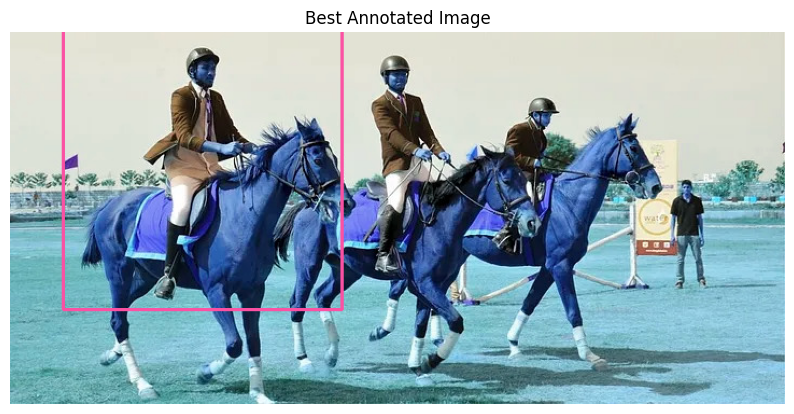

In [47]:
import matplotlib.pyplot as plt
import cv2

# Load the best annotated image
best_img_path = "final_annotated.png"
img = cv2.imread(best_img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis('off')
plt.title("Best Annotated Image")
plt.show()
